In [1]:
import pandas as pd

data_source = "/home/fra/DataMart/datacentre/olddata/"
train_file = "adult_train.csv"
test_file = "adult_test.csv"

# load data
df = pd.read_csv(data_source + train_file)
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [2]:
import sys
mylib = '/home/fra/Project/pyProj/mlib'
sys.path.append(mylib)

In [3]:
exclusions=['DATA_DT', 'PROCESS_DTTM', 'GCIS_KEY']
target_col = 'INCOME'

In [4]:
import utility as util
import explore as ex
import pipeline as pl
import transform as trf
import model as ml
from imp import reload

In [5]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix

In [6]:
def print_model_performance(model, X_test, y_test):
    predictions = model.predict(X_test)
    pred_prob = model.predict_proba(X_test)

    print("Accuracy: %f" % accuracy_score(y_test, predictions))
    print("Confustion Matrix: ")
    print(confusion_matrix(y_true=y_test, y_pred=predictions))
    print("AUC Score: %f" % roc_auc_score(y_test, pred_prob[:,1]))
    print("GINI Coefficient: %f" % (roc_auc_score(y_test, pred_prob[:,1])*2-1))

In [7]:
from sklearn.preprocessing import StandardScaler, OrdinalEncoder

In [8]:
stp = pl.StandardPipeline(target_col, exclusions)
stp.process(df, ntransformer=StandardScaler, ctransformer=OrdinalEncoder)

In [9]:
(X, y) = stp.out()

In [10]:
features = stp.features
features

Index(['AGE', 'WORKCLASS', 'FNLWGT', 'EDUCATION', 'EDUCATION-NUM',
       'MARITAL-STATUS', 'OCCUPATION', 'RELATIONSHIP', 'RACE', 'SEX',
       'CAPITAL-GAIN', 'CAPITAL-LOSS', 'HOURS-PER-WEEK', 'NATIVE-COUNTRY'],
      dtype='object')

In [11]:
from sklearn.model_selection import train_test_split
features = df.columns
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

### XGB

In [12]:
reload(ml)

<module 'model' from '/home/fra/Project/pyProj/mlib/model.py'>

In [13]:
import xgboost as xgb

In [14]:
xgb_grid_param = {'n_estimators': [50, 100], 'max_depth': [3, 4]}

In [15]:
model = ml.BinaryClassifier(xgb.XGBClassifier())

In [16]:
model.tune(X_train, y_train, xgb_grid_param)

Best params:
{'max_depth': 4, 'n_estimators': 50}


BinaryClassifier(estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                         colsample_bylevel=1,
                                         colsample_bynode=1, colsample_bytree=1,
                                         gamma=0, gpu_id=-1,
                                         importance_type='gain',
                                         interaction_constraints='',
                                         learning_rate=0.300000012,
                                         max_delta_step=0, max_depth=4,
                                         min_child_weight=1, missing=nan,
                                         monotone_constraints='()',
                                         n_estimators=50, n_jobs=0,
                                         num_parallel_tree=1,
                                         objective='binary:logistic',
                                         random_state=0, reg_alpha=0,
                                   

In [17]:
print_model_performance(model, X_test, y_test)

Accuracy: 0.871123
Confustion Matrix: 
[[6989  410]
 [ 849 1521]]
AUC Score: 0.929073
GINI Coefficient: 0.858147


In [20]:
model.key_drivers(stp.features)

,name,value
0,RELATIONSHIP,0.360057
1,EDUCATION-NUM,0.151971
2,CAPITAL-GAIN,0.111673
3,MARITAL-STATUS,0.105580
4,AGE,0.054257
5,CAPITAL-LOSS,0.051150
6,HOURS-PER-WEEK,0.037196
7,OCCUPATION,0.033523
8,SEX,0.032177
9,WORKCLASS,0.019568


In [21]:
model.cross_validate(X_train, y_train, scoring='roc_auc')

5-Fold score: 0.924 +/- 0.003


array([0.92516494, 0.92153593, 0.92183773, 0.923768  , 0.93009476])

### Evaluator

In [24]:
y_proba = model.estimator.predict_proba(X_test)

In [22]:
ev = ml.BinaryClassificationEvaluator(model)

In [25]:
ev.get_lift(y_test, y_proba, bypct=False)

rank
1.0     3.839269
2.0     2.632642
3.0     1.700248
4.0     0.995679
5.0     0.502058
6.0     0.206730
7.0     0.092818
8.0     0.016876
9.0     0.008438
10.0    0.004223
dtype: float64

In [26]:
ev.get_lift(y_test, y_proba, bypct=False, cumulative=True)

rank
1.0     3.839269
2.0     3.235956
3.0     2.724053
4.0     2.291959
5.0     1.933979
6.0     1.646104
7.0     1.424206
8.0     1.248290
9.0     1.110529
10.0    1.000000
dtype: float64

In [159]:
ev.get_lift(y_test, y_proba, bypct=False)

rank
1.0     3.962509
2.0     2.578434
3.0     1.621223
4.0     1.017576
5.0     0.521723
6.0     0.159535
7.0     0.081923
8.0     0.047429
9.0     0.008624
10.0    0.000000
dtype: float64

In [160]:
ev.get_lift(y_test, y_proba, bypct=False, cumulative=True)

rank
1.0     3.962509
2.0     3.270472
3.0     2.720722
4.0     2.294935
5.0     1.940293
6.0     1.643500
7.0     1.420418
8.0     1.248794
9.0     1.110997
10.0    1.000000
dtype: float64

In [161]:
ev.get_roc_curve(X_test, y_test)

(array([0.        , 0.        , 0.        , ..., 0.99785235, 0.99812081,
        1.        ]),
 array([0.00000000e+00, 4.31220354e-04, 1.12117292e-02, ...,
        1.00000000e+00, 1.00000000e+00, 1.00000000e+00]),
 array([1.9998162e+00, 9.9981612e-01, 9.9965334e-01, ..., 3.2393618e-05,
        3.1479718e-05, 3.3891508e-06], dtype=float32))

In [167]:
import plot

In [340]:
reload(plot)
reload(ml)
reload(util)


<module 'utility' from '/home/fra/Project/pyProj/mlib/utility.py'>

In [341]:
ev = ml.BinaryClassificationEvaluator(model)

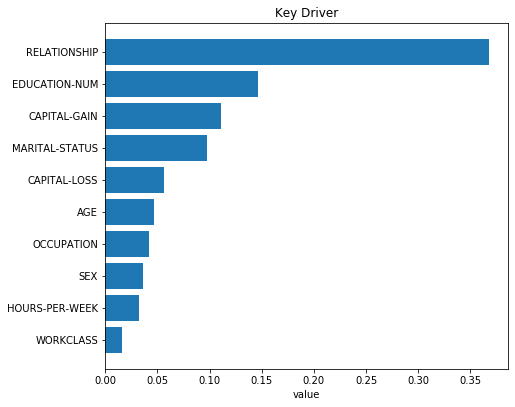

In [343]:
ev.plot_top_drivers(features, 10)

In [328]:
ev.performance_summary(X_test, y_test)

{'Accuracy': 0.8726584092537619,
 'Consfusion Matrix': array([[7024,  426],
        [ 818, 1501]]),
 'AUC': 0.9284836382263819,
 'Gini': 0.8569672764527638}

In [329]:
mapping = stp.mapping

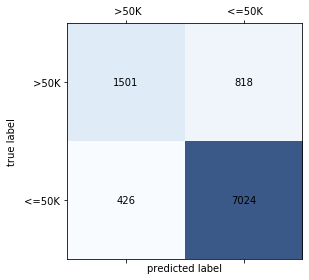

In [330]:
ev.plot_confusion_matrix(X_test, y_test, mapping)

In [331]:
mapping

{' <=50K': 0, ' >50K': 1}

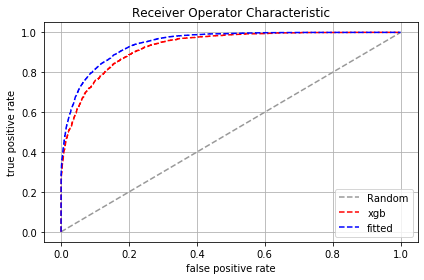

In [332]:
ev.plot_roc_curve(X_test, y_test, 'xgb', X_train, y_train, 'fitted')

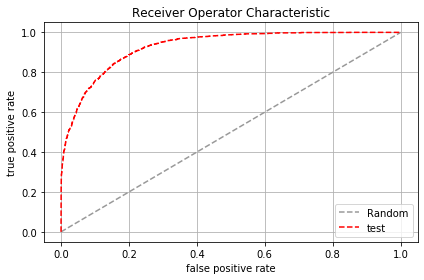

In [333]:
ev.plot_roc_curve(X_test, y_test)

In [335]:
drivers = model.key_drivers(features)

In [337]:
drivers.iloc[:10,:]

,name,value
0,RELATIONSHIP,0.368085
1,EDUCATION-NUM,0.146158
2,CAPITAL-GAIN,0.111475
3,MARITAL-STATUS,0.097176
4,CAPITAL-LOSS,0.056003
5,AGE,0.046752
6,OCCUPATION,0.041575
7,SEX,0.036029
8,HOURS-PER-WEEK,0.032438
9,WORKCLASS,0.015965
